# Adversarial search on tic-tac-toe

Tic-tac-toe is maybe the simplest game with two players, but where it's also possible to implement strategies that generalise to more complex games. These notes look at the general steps in modelling adversarial search through tic-tac-toe (ttt).

There are three steps at a high-level:
- Representing the problem state
- Defining the problem interface
- Applying the min-max algorithm

In [1]:
%reset -f

## Representing the problem state

In [2]:
# represent state with named tuple
# player attribute is 0 or 1 and denotes player to move
# board attribute is 2-d string array - '' for blank, 'X' for P0, 'O' for P1
from collections import namedtuple
import numpy as np

# namedtuple is a nice option since it is immutable, and well aligned to functional approach
Game_state_ttt = namedtuple('Game_state_ttt', 'player board')

In [3]:
# instantiate an empty board 
empty_board_state = Game_state_ttt(player=0, board=np.array([['_', '_', '_'], ['_', '_', '_'], ['_', '_', '_']]))
print(empty_board_state)

# ...and one with P1 winning
p0_wins_state = Game_state_ttt(player=1, board=np.array([['X', 'X', 'X'], ['O', 'O', '_'], ['_', '_', '_']]))
print(p0_wins_state)

# ...and one with P1 about to win
p0_about_to_win_state = Game_state_ttt(player=0, board=np.array([['X', 'X', '_'], ['O', 'O', '_'], ['_', '_', '_']]))
print(p0_about_to_win_state)

# ...and one with P1 about to lose
p0_about_to_lose_state = Game_state_ttt(player=1, board=np.array([['X', 'X', '_'], ['O', 'O', '_'], ['X', '_', '_']]))
print(p0_about_to_lose_state)


Game_state_ttt(player=0, board=array([['_', '_', '_'],
       ['_', '_', '_'],
       ['_', '_', '_']], dtype='<U1'))
Game_state_ttt(player=1, board=array([['X', 'X', 'X'],
       ['O', 'O', '_'],
       ['_', '_', '_']], dtype='<U1'))
Game_state_ttt(player=0, board=array([['X', 'X', '_'],
       ['O', 'O', '_'],
       ['_', '_', '_']], dtype='<U1'))
Game_state_ttt(player=1, board=array([['X', 'X', '_'],
       ['O', 'O', '_'],
       ['X', '_', '_']], dtype='<U1'))


In [4]:
# might be a nicer way to print the board state
Game_state_ttt.__repr__ = lambda gs: 'P' + str(gs.player) + ' to move\n' + str(gs.board)
print(empty_board_state)
print(p0_wins_state)
print(p0_about_to_win_state)
print(p0_about_to_lose_state)

P0 to move
[['_' '_' '_']
 ['_' '_' '_']
 ['_' '_' '_']]
P1 to move
[['X' 'X' 'X']
 ['O' 'O' '_']
 ['_' '_' '_']]
P0 to move
[['X' 'X' '_']
 ['O' 'O' '_']
 ['_' '_' '_']]
P1 to move
[['X' 'X' '_']
 ['O' 'O' '_']
 ['X' '_' '_']]


## Defining the problem interface

In [5]:
# define the interface as the set of functions associated with the game state
# since this is a functional approach, functions will map between, or act on, a given state
# (vs. oop where internal state may be modified)

# 1. actions
# 2. result
# 3. is_terminal
# 4. utility

### _actions_

In [6]:
# 1. actions

# use a namedtuple to represent the action
# the function then returns a list of actions
Action_ttt = namedtuple('Action_ttt', 'row col entry')

next_player_dict = {0 : 1, 1 : 0}
player_entry_dict = {0 : 'X', 1: 'O'}

def actions_ttt(gs : Game_state_ttt) -> [Action_ttt]:
    """
    returns list of actions from current state
    allowed actions are for the active player to put their mark on any empty square
    """
    entry = player_entry_dict[gs.player]
    return [Action_ttt(row, col, entry) for row in range(3) for col in range(3) if gs.board[row, col] == '_']

# if we apply this to an empty board, we expect nine actions
assert len(actions_ttt(empty_board_state)) == 9

### _result_

In [7]:
# 2. result

def result_ttt(gs : Game_state_ttt, a : Action_ttt) -> Game_state_ttt:
    """
    next game state produced by applying action
    note that board is copied so present state is not modified
    """
    next_player = next_player_dict[gs.player]
    next_board = gs.board.copy()
    next_board[a.row, a.col] = a.entry
    return Game_state_ttt(player=next_player, board=next_board)

# check that if we apply the 9 actions to the empty board, we get states returned
next_states_from_empty_board = [result_ttt(empty_board_state, a) for a in actions_ttt(empty_board_state)]
assert all([type(gs) == Game_state_ttt for gs in next_states_from_empty_board])

# also print to check that next states are as expected
print(next_states_from_empty_board)

[P1 to move
[['X' '_' '_']
 ['_' '_' '_']
 ['_' '_' '_']], P1 to move
[['_' 'X' '_']
 ['_' '_' '_']
 ['_' '_' '_']], P1 to move
[['_' '_' 'X']
 ['_' '_' '_']
 ['_' '_' '_']], P1 to move
[['_' '_' '_']
 ['X' '_' '_']
 ['_' '_' '_']], P1 to move
[['_' '_' '_']
 ['_' 'X' '_']
 ['_' '_' '_']], P1 to move
[['_' '_' '_']
 ['_' '_' 'X']
 ['_' '_' '_']], P1 to move
[['_' '_' '_']
 ['_' '_' '_']
 ['X' '_' '_']], P1 to move
[['_' '_' '_']
 ['_' '_' '_']
 ['_' 'X' '_']], P1 to move
[['_' '_' '_']
 ['_' '_' '_']
 ['_' '_' 'X']]]


### _is_terminal_

In [8]:
# 3. is_terminal

def is_terminal_ttt(gs : Game_state_ttt, apply_no_squares_check=True) -> bool:
    """
    returns True if no squares to play
    or if there is row, col or diag or 'X's or 'O's
    add optional argument that allows by-pass of no-squares check
    this is useful to discern between draws and win/loss
    """
    if apply_no_squares_check:
        if np.sum(gs.board == '_') == 0:
            return True
    
    # cols
    for i in range(3):
        if (gs.board[i, 0] != '_') and (gs.board[i, 0] == gs.board[i, 1] == gs.board[i, 2]):
            return True
    
    # rows
    for i in range(3):
        if (gs.board[0, i] != '_') and (gs.board[0, i] == gs.board[1, i] == gs.board[2, i]):
            return True

    # forward diag
    if (gs.board[0, 0] != '_') and (gs.board[0, 0] == gs.board[1, 1] == gs.board[2, 2]):
        return True

    # backward diag
    if (gs.board[2, 0] != '_') and (gs.board[2, 0] == gs.board[1, 1] == gs.board[0, 2]):
        return True
    
    return False

# check that all states from empty board are not terminal
# and that p1 winning board is
assert all([is_terminal_ttt(gs) == False for gs in next_states_from_empty_board])
assert is_terminal_ttt(p0_wins_state) == True

### _utility_

In [9]:
# 4. utility

terminal_state_player_utility_dict = {0 : -float('inf'), 1: float('inf')}

def utility_ttt(gs : Game_state_ttt) -> float:
    """
    return 0 is game is not terminal
    return 0 if game is a draw
    return +inf if p0 wins - next to play is p1
    return -inf if p1 wins - next to play is p0
    """
    if is_terminal_ttt(gs):
        if is_terminal_ttt(gs, apply_no_squares_check=False):
            return terminal_state_player_utility_dict[gs.player]
        else:
            return 0
    else:
        return 0
    
# check that p1 win returns +inf and that next states from empty board return 0
assert utility_ttt(p0_wins_state) == float('inf')
assert all([utility_ttt(gs) == 0 for gs in next_states_from_empty_board])

### Combine into single interface

Rather than pass in the functions separately to the min-max algorithm, we can package them into a single interface structure. As for the game state this can be as simple as using a namedtuple. We also include the start board since it's useful to have as part of the interface; it's not a function but it is static.

In [10]:
Adversarial_Game_Interface = namedtuple('Adversarial_Game_Interface', 'actions result is_terminal utility start_state')
agi_ttt = Adversarial_Game_Interface(actions=actions_ttt,
                          result=result_ttt,
                          is_terminal=is_terminal_ttt,
                          utility=utility_ttt,
                          start_state=empty_board_state)


## Applying the min-max algorithm

In [11]:
# we have defined the state + interface
# now we can define the functions required for the min-max algorithm

# note that the interface object is passed in to abstract the problem

def min_value(gs, agi) -> float:
    """
    return the min of the max values from the next states reached
    if state is terminal, return the utility directly
    """
    if agi.is_terminal(gs):
        return agi.utility(gs)
    
    next_states = [agi.result(gs, a) for a in agi.actions(gs)]
    next_max_values = [max_value(gs, agi) for gs in next_states]
    return min(next_max_values)
    
def max_value(gs, agi) -> float:
    """
    return the max of the min values from the next states reached
    if state is terminal, return the utility directly
    """
    if agi.is_terminal(gs):
        return agi.utility(gs)
    
    next_states = [agi.result(gs, a) for a in agi.actions(gs)]
    next_min_values = [min_value(gs, agi) for gs in next_states]
    return max(next_min_values)


In [12]:
# we can run this function from the empty board
print(f'max value from empty board: {max_value(empty_board_state, agi_ttt)}')

# the answer of zero tells us that, if we apply this algorithm, we can guarantee at least a draw
# that tallies with anyone who's ever played the game!
# this takes ~ 20 seconds to run because there are ~9! states
# (less than 9! since some will finish early)

# we can look one layer lower by applying the min value to the next states from the empty board
# (this would be the oppo's turn, so they are trying to minimise the score)
print(f'max value from empty board: {[min_value(gs, agi_ttt) for gs in next_states_from_empty_board]}')

# we can run specific checks against the states where p1 is about to win or lose
assert max_value(p0_about_to_win_state, agi_ttt) == float('inf')
assert min_value(p0_about_to_lose_state, agi_ttt) == -float('inf')

max value from empty board: 0
max value from empty board: [0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
# note that the max-min value call needs to be aligned to the active player
# e.g. for the empty board when it is p1 to move, then we call max_value
# but when it's p2's turn, we must call min_value

# this is perhaps mis-leading since the max_value call would in practice be made once from the empty board
# but an interesting aside + it feeds into the next step to combine the functions

# if we get this wrong, we get the wrong result
# e.g. consider the simple state when p0 is about to lose
# all p2 has to do is place an 'O' in the middle-right segment
print('last move!')
print(p0_about_to_lose_state)
print('\n')

# we can view the subsequent states and their utility values
next_states_from_p0_losing_board = [result_ttt(p0_about_to_lose_state, a) for a in actions_ttt(p0_about_to_lose_state)]
next_states_from_p0_losing_board_min_values = [min_value(gs, agi_ttt) for gs in next_states_from_p0_losing_board]
next_states_from_p0_losing_board_max_values = [max_value(gs, agi_ttt) for gs in next_states_from_p0_losing_board]

# if we call the min of max values, we return the -inf and assign the loss
# if we call the max of min values, we return the +inf that would result
# ...from P2 not making the winning move and allowing P1 to do so
for i, gs in enumerate(next_states_from_p0_losing_board):
    print(gs.__repr__() + '\n' + 
          f'min value: {str(next_states_from_p0_losing_board_min_values[i])}' + '\n' + 
          f'max value: {str(next_states_from_p0_losing_board_max_values[i])}' + '\n')

last move!
P1 to move
[['X' 'X' '_']
 ['O' 'O' '_']
 ['X' '_' '_']]


P0 to move
[['X' 'X' 'O']
 ['O' 'O' '_']
 ['X' '_' '_']]
min value: 0
max value: 0

P0 to move
[['X' 'X' '_']
 ['O' 'O' 'O']
 ['X' '_' '_']]
min value: -inf
max value: -inf

P0 to move
[['X' 'X' '_']
 ['O' 'O' '_']
 ['X' 'O' '_']]
min value: 0
max value: inf

P0 to move
[['X' 'X' '_']
 ['O' 'O' '_']
 ['X' '_' 'O']]
min value: 0
max value: inf



### Combining _min_value_ and _max_value_

Looking at min_value and max_value, they're basically the same. We can combine the functions by calling max or min depending on the active player. Since we will build on the initial definition, it's useful to set out the various iterations as follows.

1. basic min-max
2. add visulaisation
3. add depth cutoff
4. add evaluation function
5. add alpha-beta pruning

__v1. basic min-max__

In [14]:
player_to_min_or_max = {0 : max, 1 : min}

def minmax_value(gs, agi) -> float:
    """
    return the min(max) of the max(min) values from the next states reached
    if state is terminal, return the utility directly
    max of mins: p0
    min or maxs: p1
    """
    if agi.is_terminal(gs):
        return agi.utility(gs)
    next_states = [agi.result(gs, a) for a in agi.actions(gs)]
    next_values = [minmax_value(gs, agi) for gs in next_states]
    min_or_max = player_to_min_or_max[gs.player]
    return min_or_max(next_values)
    
assert minmax_value(p0_about_to_win_state, agi_ttt) == float('inf')
assert minmax_value(p0_about_to_lose_state, agi_ttt) == -float('inf')
#assert minmax_value(empty_board_state) == 0 # takes a while in case commented

### Min-max decision

In [15]:
# the minmax_value function returns a value
# what we want is a function that returns an action 
# specifically, an action that returns the best value

def minmax_decision(gs, agi):
    """
    get the actions
    get the results - next states - of applying those actions
    return the action that maximises/minimises the utility in the next state
    (max or min depending on who is playing)
    """
    next_actions = agi.actions(gs)
    next_states = [agi.result(gs, a) for a in next_actions]
    next_utilities = [minmax_value(ngs, agi) for ngs in next_states]
    min_or_max = player_to_min_or_max[gs.player]
    return min_or_max([(na, nu) for na, nu in zip(next_actions, next_utilities)], key=lambda x: x[1])[0]
    

In [16]:
# we can check this makes sense with the about-to-win-or-lose states
print(p0_about_to_win_state)
minmax_decision(p0_about_to_win_state, agi_ttt)

P0 to move
[['X' 'X' '_']
 ['O' 'O' '_']
 ['_' '_' '_']]


Action_ttt(row=0, col=2, entry='X')

In [17]:
print(p0_about_to_lose_state)
minmax_decision(p0_about_to_lose_state, agi_ttt)

P1 to move
[['X' 'X' '_']
 ['O' 'O' '_']
 ['X' '_' '_']]


Action_ttt(row=1, col=2, entry='O')

### Adding visualisation

In [18]:
# min-max is an implicit search algorithm that generates successive game states
# we can visualise how min-max works by collating the information at each stage
# graphviz is a great library for doing this

__v2. add visualisation__

In [19]:
def minmax_value(gs, agi, depth = 0, node_id = 0) -> float:
    """
    return the min(max) of the max(min) values from the next states reached
    if state is terminal, return the utility directly
    max of mins: p0
    min or maxs: p1
    """
    
    #### added ####
    # initialise on first call
    if depth == 0:
        minmax_value.states = {}
        minmax_value.state_mappings = {}
    
    #### added ####
    # add state info
    minmax_value.states[node_id] = gs
    
    if agi.is_terminal(gs):
        return agi.utility(gs)
    next_states = [agi.result(gs, a) for a in agi.actions(gs)]
    
    #### added ####
    # add mapping info
    next_node_ids = [max(minmax_value.states.keys()) + 1 + i for i in range(len(next_states))]
    minmax_value.state_mappings[node_id] = next_node_ids
    for nni in next_node_ids:
        minmax_value.states[nni] = '' # initialise so that keys are picked up in max-by-call
        
    next_values = [minmax_value(gs,
                                         agi,
                                         depth = depth + 1, 
                                         node_id = next_node_ids[i]) for i, gs in enumerate(next_states)]
    min_or_max = player_to_min_or_max[gs.player]
    return min_or_max(next_values)
    
assert minmax_value(p0_about_to_win_state, agi_ttt) == float('inf')
assert minmax_value(p0_about_to_lose_state, agi_ttt) == -float('inf')

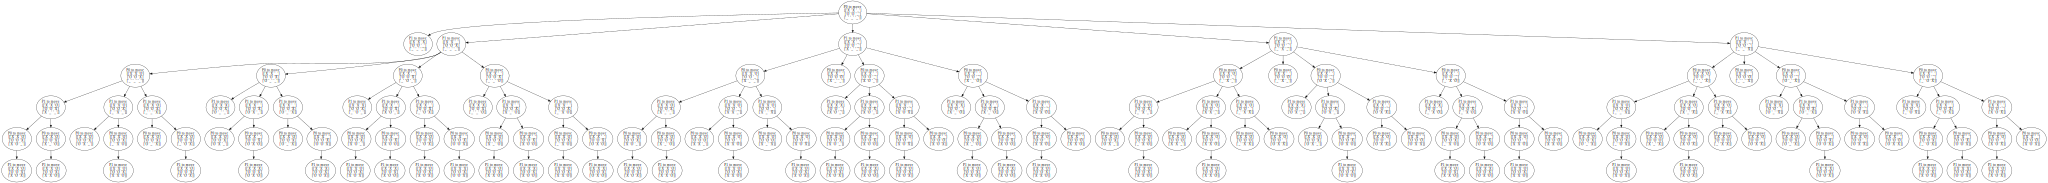

In [20]:
# the state is captured within a single initial call to the function
# we apply the graphviz library to visualise the game sequence
# lots of complexity for a game with a single end move!
minmax_value(p0_about_to_win_state, agi_ttt)

import graphviz
g = graphviz.Digraph()
for node_id, node_str in minmax_value.states.items():
    g.node(str(node_id), str(node_str))
    
for node_id, next_nodes in minmax_value.state_mappings.items():
    for nn in next_nodes:
        g.edge(str(node_id), str(nn))
        
g

# Adversarial search on isolation

## Representing the problem state

In [21]:
# similar to ttt
# represent state with named tuple
# player attribute is 0 or 1 and denotes player to move
# board attribute is 2-d string array - '' for blank, 'X' for blocked, '0' for P0, '1' for P1

# namedtuple is a nice option since it is immutable, and well aligned to functional approach
# loc maps player to location on board, initially None for both players
Game_state_iso = namedtuple('Game_state_iso', 'player board loc')

In [22]:
# instantiate an empty board 
empty_board_state_iso = Game_state_iso(
    player=0, 
    board=np.array([['_', '_', '_', '_', '_'],
                    ['_', '_', '_', '_', '_'],
                    ['_', '_', '_', '_', '_'],
                    ['_', '_', '_', '_', '_'],
                    ['_', '_', '_', '_', '_']]),
    loc = {0 : None, 1 : None})

# ...and one with P1 winning
p0_wins_state_iso = Game_state_iso(
    player=1, 
    board=np.array([['_', '_', '_', 'X', '1'],
                    ['_', '_', '_', 'X', 'X'],
                    ['_', 'X', 'X', '_', '_'],
                    ['_', '0', 'X', '_', '_'],
                    ['_', '_', 'X', '_', '_']]),
    loc = {0 : (3, 1), 1 : (0, 4)})

# ...and one with P1 about to win
p0_about_to_win_state_iso = Game_state_iso(
    player=1, 
    board=np.array([['_', '_', 'X', '_', '1'],
                    ['_', '_', 'X', 'X', 'X'],
                    ['_', 'X', 'X', '_', '_'],
                    ['_', '0', 'X', 'X', '_'],
                    ['_', '_', 'X', '_', '_']]),
    loc = {0 : (3, 1), 1 : (0, 4)})

# ...and one with P1 about to lose (switch positions from above)
p0_about_to_lose_state_iso = Game_state_iso(
    player=0, 
    board=np.array([['_', '_', 'X', '_', '0'],
                    ['_', '_', 'X', 'X', 'X'],
                    ['_', 'X', 'X', '_', '_'],
                    ['_', '1', 'X', 'X', '_'],
                    ['_', '_', 'X', '_', '_']]),
    loc = {0 : (0, 4), 1 : (3, 1)})

In [23]:
# add a nicer way to print the board state
Game_state_iso.__repr__ = lambda gs: 'P' + str(gs.player) + ' to move\n' + str(gs.board)

In [24]:
print(empty_board_state_iso)
print(p0_wins_state_iso)
print(p0_about_to_win_state_iso)
print(p0_about_to_lose_state_iso)

P0 to move
[['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']]
P1 to move
[['_' '_' '_' 'X' '1']
 ['_' '_' '_' 'X' 'X']
 ['_' 'X' 'X' '_' '_']
 ['_' '0' 'X' '_' '_']
 ['_' '_' 'X' '_' '_']]
P1 to move
[['_' '_' 'X' '_' '1']
 ['_' '_' 'X' 'X' 'X']
 ['_' 'X' 'X' '_' '_']
 ['_' '0' 'X' 'X' '_']
 ['_' '_' 'X' '_' '_']]
P0 to move
[['_' '_' 'X' '_' '0']
 ['_' '_' 'X' 'X' 'X']
 ['_' 'X' 'X' '_' '_']
 ['_' '1' 'X' 'X' '_']
 ['_' '_' 'X' '_' '_']]


## Defining the problem interface

### _actions_

In [25]:
# 1. actions

# use a namedtuple to represent the action
# the function then returns a list of actions
Action_iso = namedtuple('Action_iso', 'row col entry')

next_player_dict = {0 : 1, 1 : 0}
player_entry_dict = {0 : '0', 1: '1'}

moves = {
    'l'  : (-1,  0),
    'r'  : ( 1,  0),
    'u'  : ( 0,  1),
    'd'  : ( 0, -1),
    'ld' : (-1, -1),
    'ur' : ( 1,  1),
    'lu' : (-1,  1),
    'rd' : ( 1, -1)
}

def on_board(coord):
    return (coord[0] >= 0 and coord[0] < 5 and coord[1] >= 0 and coord[1] < 5)

def actions_iso(gs : Game_state_iso) -> [Action_iso]:
    """
    returns list of actions from current state
    allowed actions are for the active player to move to a blank square in their arc
    i.e. left-right, up-down, + 2 x diagonals
    """
    player = gs.player
    entry = player_entry_dict[player]
    loc = gs.loc[player]
    board = gs.board
    
    if loc:
        # start from location with empty list of co-ords
        # go in each of eight directions
        # while still on board and square is blank, add co-ord to list of actions
        actions = []  
        for m in moves.values():
            loc2 = loc
            loc2 = (loc2[0] + m[0], loc2[1] + m[1])
            while on_board(loc2) and board[loc2[0], loc2[1]] == "_":
                actions.append(Action_iso(loc2[0], loc2[1], entry))
                loc2 = (loc2[0] + m[0], loc2[1] + m[1])
        return actions
        
    else:
        # initial move
        # go anywhere that is marked as '_'
        return [Action_iso(row, col, entry) for row in range(5) for col in range(5) if gs.board[row, col] == '_']

# if we apply this to an empty board, we expect 25 actions
assert len(actions_iso(empty_board_state_iso)) == 25

In [26]:
# we can also check that the end/near-end games are consistent with our expectations
assert len(actions_iso(p0_wins_state_iso)) == 0
assert actions_iso(p0_about_to_win_state_iso) == [Action_iso(row=0, col=3, entry='1')]
assert actions_iso(p0_about_to_lose_state_iso) == [Action_iso(row=0, col=3, entry='0')]


### _result_

In [27]:
# 2. result

def result_iso(gs : Game_state_iso, a : Action_iso) -> Game_state_iso:
    """
    next game state produced by applying action
    note that board is copied so present state is not modified
    """
    player = gs.player
    next_player = next_player_dict[player]
    loc = gs.loc
    next_board = gs.board.copy()
    # update where player moves to ('0' or '1'), and where they've moved from ('X')
    # note that 'X' only placed if there is a previous loc
    next_board[a.row, a.col] = a.entry
    if loc[player] is not None:
        next_board[loc[player][0], loc[player][1]] = 'X'
    return Game_state_iso(player=next_player, board=next_board, 
                          loc = {player      : (a.row, a.col),
                                 next_player : loc[next_player]})

# check that if we apply the 25 actions to the empty board, we get states returned
next_states_from_empty_board_iso = [result_iso(empty_board_state_iso, a) for a in actions_iso(empty_board_state_iso)]
assert all([type(gs) == Game_state_iso for gs in next_states_from_empty_board_iso])

# also print to check that next states are as expected
print(next_states_from_empty_board_iso)

[P1 to move
[['0' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']], P1 to move
[['_' '0' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']], P1 to move
[['_' '_' '0' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']], P1 to move
[['_' '_' '_' '0' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']], P1 to move
[['_' '_' '_' '_' '0']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']], P1 to move
[['_' '_' '_' '_' '_']
 ['0' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']], P1 to move
[['_' '_' '_' '_' '_']
 ['_' '0' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']], P1 to move
[['_' '_' '_' '_' '_']
 ['_' '_' '0' '_' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_']


### _is_terminal_

In [28]:
# 3. is_terminal

def is_terminal_iso(gs : Game_state_iso) -> bool:
    """
    returns True if current player has no moves
    then that player loses
    """
    actions = actions_iso(gs)
    return actions == []
    
# check that all states from empty board are not terminal
# and that p1 winning board is
assert all([is_terminal_iso(gs) == False for gs in next_states_from_empty_board_iso])
assert is_terminal_iso(p0_wins_state_iso) == True

### utility

In [29]:
# 4. utility

terminal_state_player_utility_dict_iso = {0 : -float('inf'), 1: float('inf')}

def utility_iso(gs : Game_state_iso) -> float:
    """
    return +inf if p0 wins - terminal and current player is p1
    return -inf if p1 wins - terminal and current player is p0
    """
    if is_terminal_iso(gs):
        return terminal_state_player_utility_dict_iso[gs.player]
    else:
        return 0
    
# check that p1 win returns +inf and that next states from empty board return 0
assert utility_iso(p0_wins_state_iso) == float('inf')
assert all([utility_iso(gs) == 0 for gs in next_states_from_empty_board_iso])

### Combine into single interface


In [30]:
agi_iso = Adversarial_Game_Interface(actions=actions_iso,
                          result=result_iso,
                          is_terminal=is_terminal_iso,
                          utility=utility_iso,
                          start_state=empty_board_state_iso)

## Extending the min-max algorithm

Tic-tac-toe has a small enough state space that we can search till the end state. That is not in general possible, so we need a different way to value a given position without searching all the way to the end.

The first step is to add a depth cutoff. Starting from zero, the depth parameter is updated by one in each step. Once it reaches the depth cutoff, the min-max value function returns. But what does it return? In the first instance we can use a placeholder of zero, and then extend this to the notion of an evaluation function, a function that, given a game state, proxies the values of the game in some way. These evaluation functions can be very simple (e.g. counting the number of pieces in chess you vs. opponent), or very complex (e.g. a neural network, as in AlphaGo), but the principle is the same.

### Add a depth cutoff

__v3. add depth cutoff__

In [31]:
def minmax_value(gs,
                 agi,
                 depth = 0, node_id = 0, depth_limit=None) -> float:
    """
    return the min(max) of the max(min) values from the next states reached
    if state is terminal, return the utility directly
    max of mins: p0
    min or maxs: p1
    
    also apply depth cutoff 
    acts in similar way to terminal check
    for the moment just return zero if depth is reached
    next step is to return an evaluation function
    """
    
    # initialise on first call
    if depth == 0:
        minmax_value.states = {}
        minmax_value.state_mappings = {}
    
    # add state info
    minmax_value.states[node_id] = gs
    
    #### added ####
    if (depth_limit is not None) and (depth >= depth_limit):
        return 0 # placeholder for evaluation function
    
    if agi.is_terminal(gs):
        return agi.utility(gs)
    next_states = [agi.result(gs, a) for a in agi.actions(gs)]
    
    # add mapping info
    next_node_ids = [max(minmax_value.states.keys()) + 1 + i for i in range(len(next_states))]
    minmax_value.state_mappings[node_id] = next_node_ids
    for nni in next_node_ids:
        minmax_value.states[nni] = '' # initialise so that keys are picked up in max-by-call
        
    next_values = [minmax_value(gs,
                              agi,
                             depth = depth + 1, 
                             node_id = next_node_ids[i],
                             depth_limit = depth_limit) for i, gs in enumerate(next_states)]
                                         
                                         
    min_or_max = player_to_min_or_max[gs.player]
    return min_or_max(next_values)
    
    

As before we can visualise how this impacts the min-max algorithm. From the empty board we can go two steps and see 25 * 24 game states.

In [32]:
minmax_value(gs = empty_board_state_iso,
                                      agi = agi_iso,
                                      depth_limit=2)

g = graphviz.Digraph()
for node_id, node_str in minmax_value.states.items():
    g.node(str(node_id), str(node_str))
    
for node_id, next_nodes in minmax_value.state_mappings.items():
    for nn in next_nodes:
        g.edge(str(node_id), str(nn))
        
g

That graph gets a little crowded....we can also see what happens if we apply a depth cutoff to an end-game. In the case that P0 is about to win, any depth cutoff of two or more will reach the end state. Note that when it is P0's turn to move, we could check for a terminal state by looking at whether both players can move, rather than just the active player (with hindsight probably the right choice!).

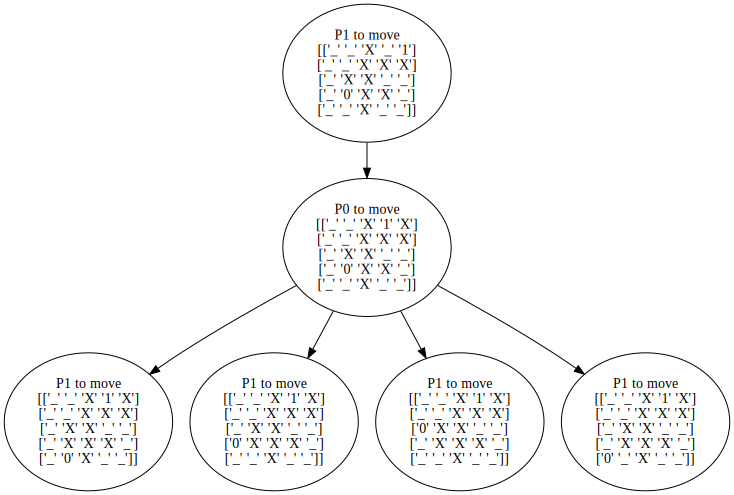

In [33]:
minmax_value(gs = p0_about_to_win_state_iso,
                                      agi = agi_iso,
                                      depth_limit=5)

g = graphviz.Digraph()
for node_id, node_str in minmax_value.states.items():
    g.node(str(node_id), str(node_str))
    
for node_id, next_nodes in minmax_value.state_mappings.items():
    for nn in next_nodes:
        g.edge(str(node_id), str(nn))
        
g

### Add an evaluation function

If we don't get to an end state then we need to estimate the value of the game. There are lots of ways to do this. Let's consider a couple of simple ones.

- number of moves for P0
- minus number moves for P1
- number of moves for P0 - number moves for P1

The first might incentise moves that lead to more moves. The second might lead to fewer moves for the opponent. The third combines the first two, so it looks for moves that open up the board (for P0) while also seeking to block the board for P1.


In [34]:
# implement these with an enum 
from enum import Enum

class EvalFunctionType_iso(Enum):
    NUM_P0_MOVES = 1
    MINUS_NUM_P1_MOVES = 2
    NUM_P0_MOVES_MINUS_NUM_P1_MOVES = 3
    
def eval_iso(gs : Game_state_iso, eval_type : EvalFunctionType_iso) -> float:
    """
    the actions function tells us how many moves the current player has
    we can create an identical board but switch players to get the opponent moves
    some redundancy in calculating the gs switch if not strictly necessary
    """
    current_moves = len(actions_iso(gs))
    gs_switch_player = Game_state_iso(
            player=next_player_dict[gs.player], 
            board=gs.board,
            loc = gs.loc)
    oppo_moves = len(actions_iso(gs_switch_player))
        
    if gs.player == 0:
        num_p0_moves, num_p1_moves = current_moves, oppo_moves
    else:
        num_p1_moves, num_p0_moves = current_moves, oppo_moves
        
    if eval_type == EvalFunctionType_iso.NUM_P0_MOVES:
        return num_p0_moves
    elif eval_type == EvalFunctionType_iso.MINUS_NUM_P1_MOVES:
        return -num_p1_moves
    elif eval_type == EvalFunctionType_iso.NUM_P0_MOVES_MINUS_NUM_P1_MOVES:
        return num_p0_moves - num_p1_moves
    else:
        raise ValueError

# basic assertions            
assert eval_iso(empty_board_state_iso, EvalFunctionType_iso.NUM_P0_MOVES) == 25        
assert eval_iso(empty_board_state_iso, EvalFunctionType_iso.MINUS_NUM_P1_MOVES) == -25  
assert eval_iso(empty_board_state_iso, EvalFunctionType_iso.NUM_P0_MOVES_MINUS_NUM_P1_MOVES) == 0          

assert eval_iso(p0_wins_state_iso, EvalFunctionType_iso.NUM_P0_MOVES) == 4        
assert eval_iso(p0_wins_state_iso, EvalFunctionType_iso.MINUS_NUM_P1_MOVES) == -0  
assert eval_iso(p0_wins_state_iso, EvalFunctionType_iso.NUM_P0_MOVES_MINUS_NUM_P1_MOVES) == 4    

assert eval_iso(p0_about_to_win_state_iso, EvalFunctionType_iso.NUM_P0_MOVES) == 4        
assert eval_iso(p0_about_to_win_state_iso, EvalFunctionType_iso.MINUS_NUM_P1_MOVES) == -1  
assert eval_iso(p0_about_to_win_state_iso, EvalFunctionType_iso.NUM_P0_MOVES_MINUS_NUM_P1_MOVES) == 3    

assert eval_iso(p0_about_to_lose_state_iso, EvalFunctionType_iso.NUM_P0_MOVES) == 1        
assert eval_iso(p0_about_to_lose_state_iso, EvalFunctionType_iso.MINUS_NUM_P1_MOVES) == -4  
assert eval_iso(p0_about_to_lose_state_iso, EvalFunctionType_iso.NUM_P0_MOVES_MINUS_NUM_P1_MOVES) == -3  

Integrate this to the mix-max code, which is getting a little bloated....! I'll try and tidy this, and the general structure, a little later. Note that the states now return a tuple, the second element of which is the evaluation function applied to the state. The state info is also added according to how the function returns i.e. base case vs. depth limit reached vs. min/max of successors.

__v4. add evaluation function__

In [35]:
def minmax_value(gs,
                  agi,
                  eval_func,
                  depth = 0, node_id = 0, depth_limit=None) -> float:
    """
    return the min(max) of the max(min) values from the next states reached
    if state is terminal, return the utility directly
    max of mins: p0
    min or maxs: p1
    
    also apply depth cutoff 
    acts in similar way to terminal check
    for the moment just return zero if depth is reached
    next step is to return an evaluation function
    """
    
    # initialise on first call
    if depth == 0:
        minmax_value.states = {}
        minmax_value.state_mappings = {}
    
    minmax_value.states[node_id] = (gs, 0) # added as initialiser
        
    
    if (depth_limit is not None) and (depth >= depth_limit):
        minmax_value.states[node_id] = (gs, eval_func(gs)) # added
        return eval_func(gs)
    
    if agi.is_terminal(gs):
        minmax_value.states[node_id] = (gs, utility(gs)) # added
        return agi.utility(gs)
    next_states = [agi.result(gs, a) for a in agi.actions(gs)]
    
    # add mapping info
    next_node_ids = [max(minmax_value.states.keys()) + 1 + i for i in range(len(next_states))]
    
    
    minmax_value.state_mappings[node_id] = next_node_ids
    for nni in next_node_ids:
        minmax_value.states[nni] = '' # initialise so that keys are picked up in max-by-call
        
    next_values = [minmax_value(gs,
                                          agi,
                                          eval_func,
                                          depth = depth + 1, 
                                          node_id = next_node_ids[i],
                                          depth_limit = depth_limit) for i, gs in enumerate(next_states)]
                                         
                                         
    min_or_max = player_to_min_or_max[gs.player]
    mmv = min_or_max(next_values)
    minmax_value.states[node_id] = (gs, mmv) # added
    return mmv
    

To test this, let's create a more interesting example, one in which P0 could win by trapping their opponent into a corner. It's P0 to move; if they move down they can guarantee victory since P1 is left with 4 squares while P0 is left with 9, assuming that they move optimally and don't trap themselves.

In [36]:
p0_can_win_by_trapping_oppo_iso = Game_state_iso(
    player=0, 
    board=np.array([['_', '_', 'X', 'X', 'X'],
                    ['_', '_', 'X', 'X', 'X'],
                    ['_', 'X', 'X', 'X', '1'],
                    ['_', '_', '0', '_', '_'],
                    ['_', '_', '_', '_', '_']]),
    loc = {0 : (3, 2), 1 : (2, 4)})

print(p0_can_win_by_trapping_oppo_iso)

P0 to move
[['_' '_' 'X' 'X' 'X']
 ['_' '_' 'X' 'X' 'X']
 ['_' 'X' 'X' 'X' '1']
 ['_' '_' '0' '_' '_']
 ['_' '_' '_' '_' '_']]


With just two moves we can see how the evaluation function works. The move it would suggest is to move straight down. This cuts off P1 so that its moves are limited whatever move it makes next i.e. the best of the worst moves from that position still yields a +3 difference in the number of moves. The worst move is the one where P0 moves straight across to try and block P1 in, but leaves open the diagonal for P1 to escape. Then P1's best move (and P0's worst) is to move diagonally down and block P0 in, resulting in a net difference of -4 moves.

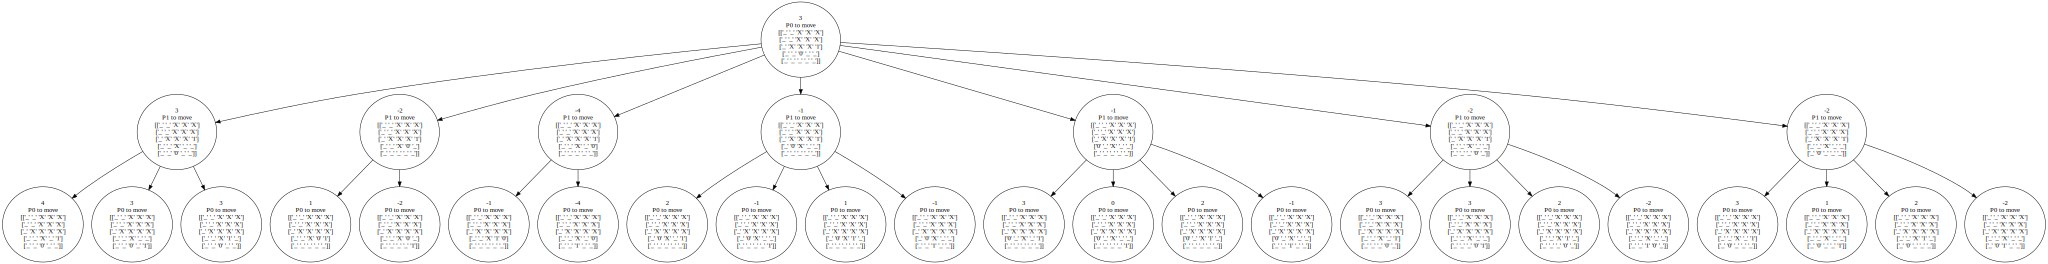

In [37]:
from functools import partial

minmax_value(
          gs = p0_can_win_by_trapping_oppo_iso,
          agi = agi_iso,
          eval_func = partial(eval_iso, eval_type = EvalFunctionType_iso.NUM_P0_MOVES_MINUS_NUM_P1_MOVES),                               
          depth_limit=2
          )

# node state is now a tuple
g = graphviz.Digraph()
for node_id, (node_str, node_eval) in minmax_value.states.items():
    g.node(str(node_id), str(node_eval) + '\n' + str(node_str)) 
    
for node_id, next_nodes in minmax_value.state_mappings.items():
    for nn in next_nodes:
        g.edge(str(node_id), str(nn))
        
g

### Add alpha-beta pruning

It look me a while to get my head around this one. There's a great youtube video that explains the crux of it: https://www.youtube.com/watch?v=l-hh51ncgDI. My own take follows below. While the algorithm is very simple, and elegant, it is also subtle and not immedialtely obvious.

#### Min-max in isolation

If we look at a given node in the min-max algorithm, there isn't much we can do to speed it up; for a max(min) node we don't know whether there is a higher (lower) value until we've looked at all of the child nodes recursing appropriately. In the example below, a min node, we don't know if the other nodes will have a value lower than 5 until we check them.

One thing we can infer, though, is that once we've seen the initial value of 5, we know that the min node will be less than or equal to 5. This becomes relevant when we're able to compare this to prior knowledge that we pass in.

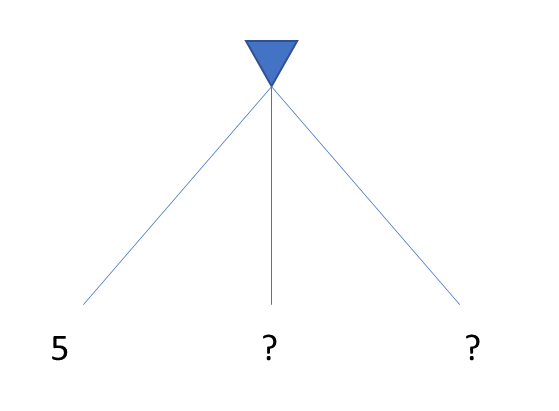

#### Minmax with info passed in

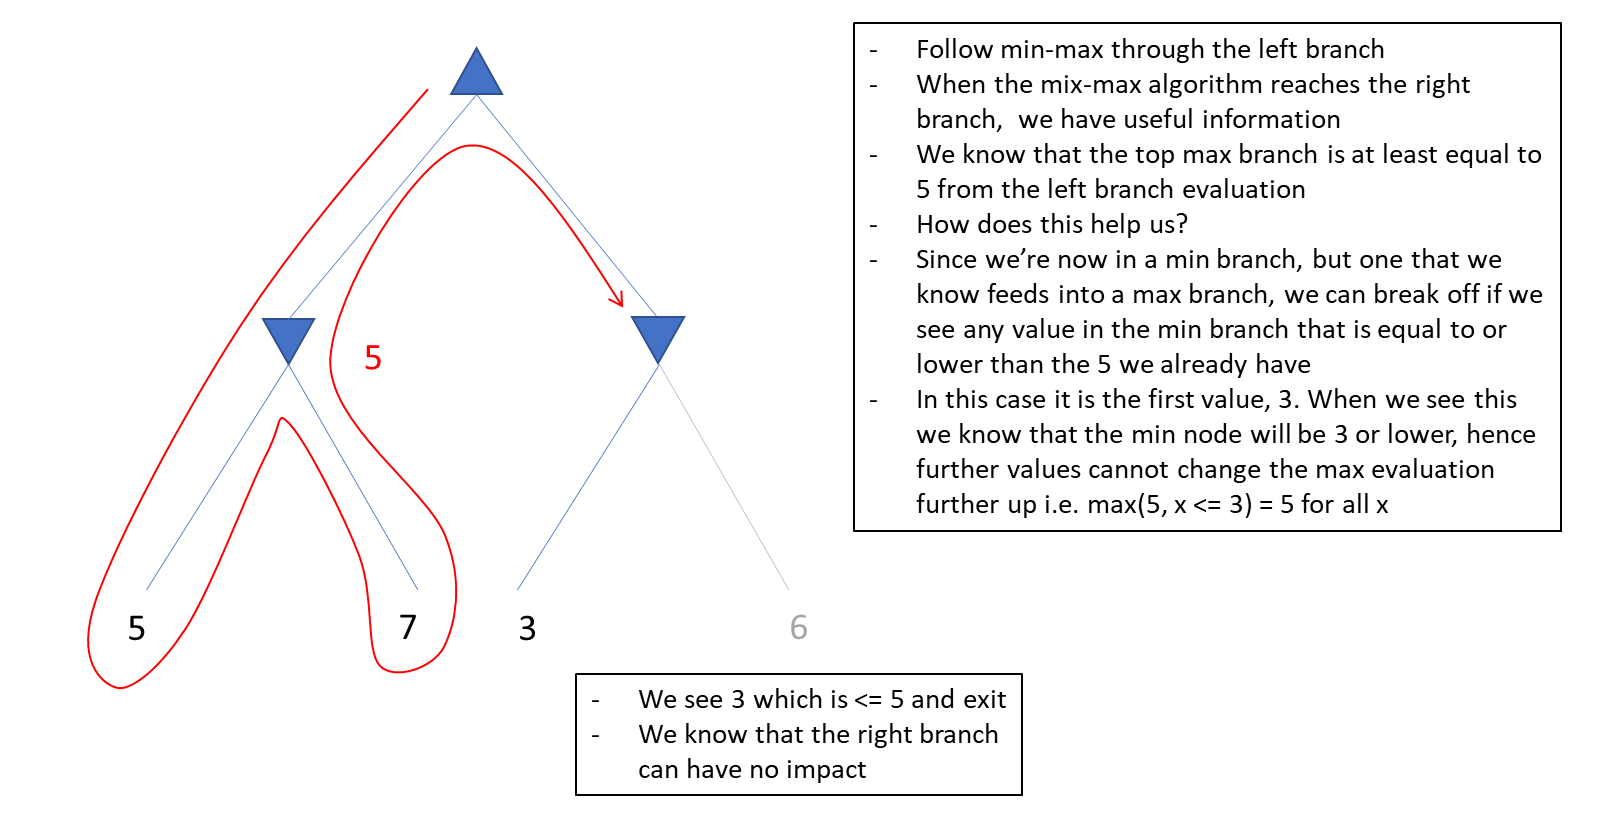

#### What alpha and beta represent

At a given node:

- alpha is the guaranteed highest value that the maximising player can achieve
- beta is the guaranteed lowest value that the minimising player can achieve

In both cases the highest / lowest values is WRT the maximing player. 

In the example above, on the right min node we have alpha = 5; we can pass this into the min node from the evaluation of its prior left sibling branch. This leads to the intuition that within a given node the value of alpha (beta) is updated to reflect the maximum (minimum) current value of the child nodes. The updated value is passed down into the child nodes of successive siblings that can enable an early stop for a given node.

The illustration below shows how alpha and beta re initialised and updated in the min-max algorithm.

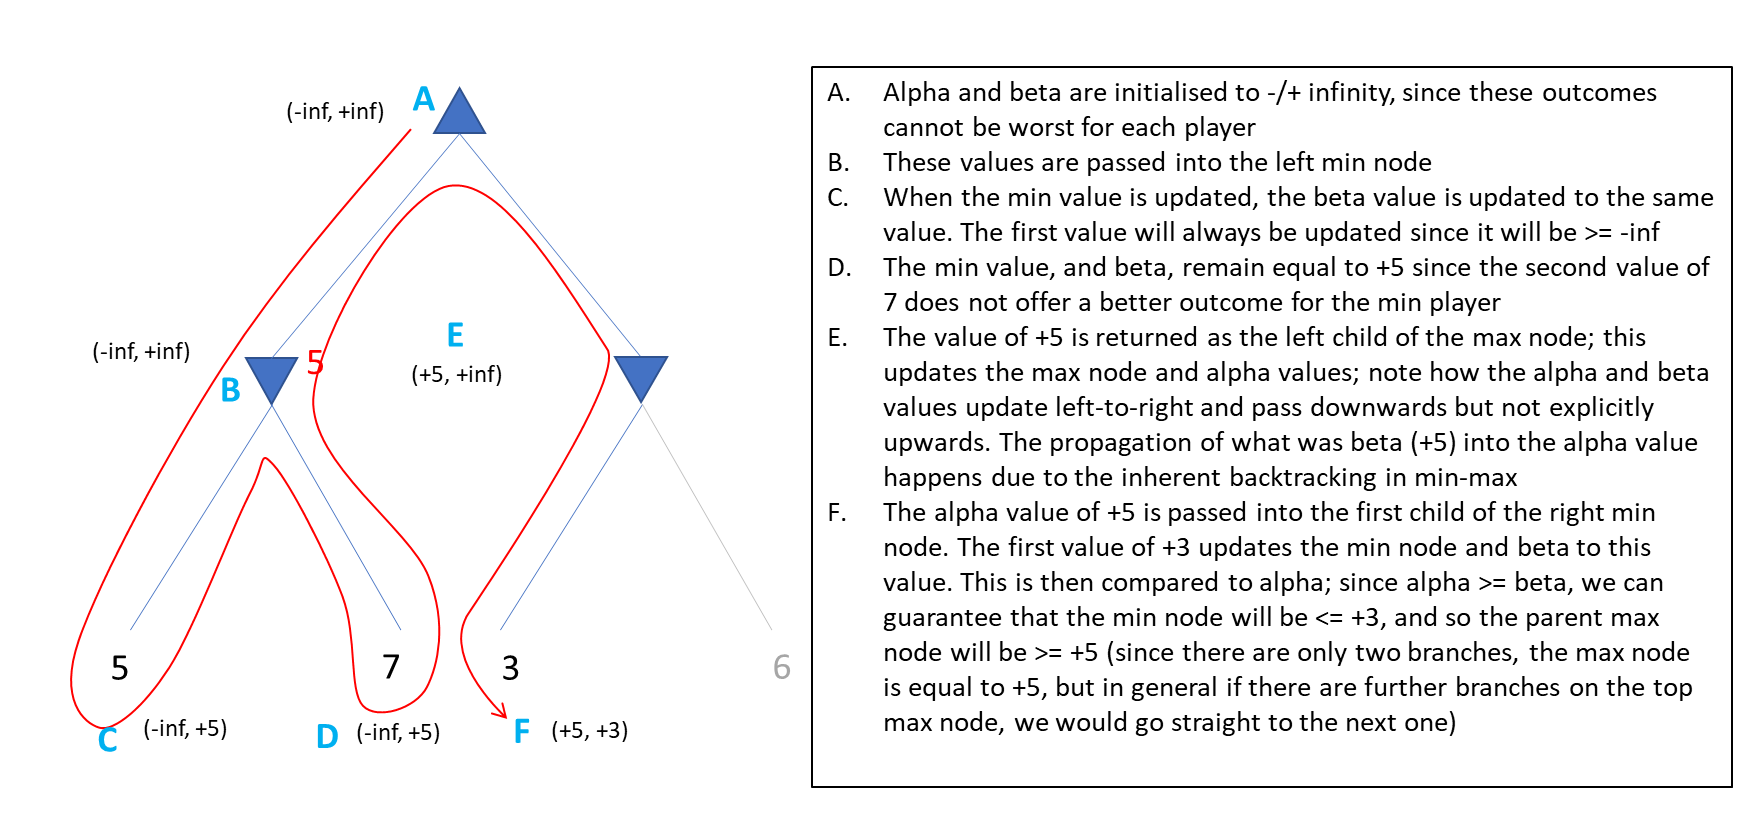

#### Implementation

Similar to previous function except:
- alpha, beta initialised on first call
- alpha (beta) updated in max (min) call
- Change from functional approach to explicit for loop since we want to return early if alpha >= beta

The code is still a little long owing to the visualisation.

In [39]:
def minmax_value(gs,
                  agi,
                  eval_func,
                  alpha, beta,
                  depth = 0, node_id = 0, depth_limit=None) -> float:
    """
    return the min(max) of the max(min) values from the next states reached
    if state is terminal, return the utility directly
    max of mins: p0
    min or maxs: p1
    
    add in alpha, beta pruning
    """
    
    # initialise on first call
    if depth == 0:
        minmax_value.states = {}
        minmax_value.state_mappings = {}
    
    minmax_value.states[node_id] = (gs, 0) # initialiser
        
    
    if (depth_limit is not None) and (depth >= depth_limit):
        minmax_value.states[node_id] = (gs, eval_func(gs))
        return eval_func(gs)
    
    if agi.is_terminal(gs):
        minmax_value.states[node_id] = (gs, utility(gs))
        return agi.utility(gs)
    next_states = [agi.result(gs, a) for a in agi.actions(gs)]
    
    # add mapping info
    next_node_ids = [max(minmax_value.states.keys()) + 1 + i for i in range(len(next_states))]
    
    
    minmax_value.state_mappings[node_id] = next_node_ids
    for nni in next_node_ids:
        minmax_value.states[nni] = '' # initialise so that keys are picked up in max-by-call
        
    next_values = [minmax_value(gs,
                                          agi,
                                          eval_func,
                                          depth = depth + 1, 
                                          node_id = next_node_ids[i],
                                          depth_limit = depth_limit) for i, gs in enumerate(next_states)]
                                         
                                         
    min_or_max = player_to_min_or_max[gs.player]
    mmv = min_or_max(next_values)
    minmax_value.states[node_id] = (gs, mmv) 
    return mmv
    

### Apply iterative deepening

# Let's play!

Notes beyond project.....
- 3 players isolation - say start with my_moves
- instead of min-max - evaluate game board from each players' perspectives - so instead of min-max-min-... we would have p1-p2-p3-p1-p2-p3-etc. so at each level we have 3 values. min-max is special case of maxn
- alpha/beta for 3 players.....? some but not all pruning possible

probabilistic games e.g. backgammon
- expctamax algorithm
- try on sloppy isolation
- adds layer in game board i.e. take this action, then A happens with PA and B happens with PB
- can implement as per deterministic games but with additional probability information, plus more child nodes as needed